In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gurobipy as gp
from gurobipy import GRB
import json

In [3]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [4]:
rng = np.random.default_rng(43)

# Scaling bounds & Capture efficiency

# Code

### Bootstrap

In [5]:
def bootstrap(sample, beta, N, tau, drop=False):
    """
    Bootstrap estimate of probabilities of all states in the sample
    Set bounds outside tau threshold truncation to [0, 1]

    sample: integer sample
    N: number of bootstrap resamples
    tau: truncation threshold
    drop: if true, values outside truncation are removed from the sample before bootstrap
    """

    # OB truncation bounds
    xmin, xmax = int(sample.min()), int(sample.max())
    sample_counts = np.bincount(sample, minlength=(xmax + 1))
    t_indices = np.where(sample_counts > tau)[0]
    tmin, tmax = int(t_indices.min()), int(t_indices.max())

    # if drop: remove values outside the truncation before bootstrapping
    if drop:
        # indices below
        Itmin = (sample >= tmin)
        # drop
        sample = sample[Itmin]
        beta = beta[Itmin]

        # indices above
        Itmax = (sample <= tmax)
        # drop
        sample = sample[Itmax]
        beta = beta[Itmax]

    # bootstrap
    prob_intervals = np.empty((2, xmax + 1))
    prob_intervals[0, :] = 0
    prob_intervals[1, :] = 1
    fm_intervals = np.empty((2, xmax + 1))
    fm_intervals[0, :] = 0
    fm_intervals[1, :] = 1

    # resample
    prob_resamples = rng.choice(sample, size=(N, len(sample)))

    # estimate over truncation
    for x in range(tmin, tmax + 1):

        '''probs'''
        # proportion of x per resample
        prob_estimates = (prob_resamples == x).mean(axis=1)
        # interval
        prob_intervals[:, x] = np.quantile(prob_estimates, [0.025, 0.975])

        '''fms'''
        # capture for cells with x observed counts
        beta_x = beta[sample == x]
        # resample
        beta_resamples = rng.choice(beta_x, size=(N, len(beta_x)))
        # estimate E[beta|m]
        fm_estimate = beta_resamples.mean(axis=1)
        # quantile for confidence intervals
        fm_intervals[:, x] = np.quantile(fm_estimate, [0.025, 0.975], axis=0)

    return tmin, tmax, prob_intervals, fm_intervals

### Standard Optimization (Downsampled)

Treat bootstrap intervals as bounds on (downsampled) probabilities

\begin{align*}
    & \hat{p_{L}} \le p(x) \le \hat{p_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & \hat{f_{L}} \le f_{x} \le \hat{f_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & \sum \limits_{x=0}^{m} p(x) \le 1 \\
    & Q(f)p = 0
\end{align*}

In [6]:
def optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, CME=True, silent=True, printing=True, time_limit=300, dist_opt=True):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probability bounds
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)], name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)], name="prob_LB")

            # f rate bounds
            model.addConstr(f[:(tmax+1)] <= fm_intervals[1, :(tmax+1)], name="f_UB")
            model.addConstr(f[:(tmax+1)] >= fm_intervals[0, :(tmax+1)], name="f_LB")

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            if CME:
                model.addConstr(
                    z == p[1] - k_tx * f[0] * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
                )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

### Scaling Optimization (Downsampled)

Treat bootstrap intervals as bounds on (downsampled) probabilities **relative** to the observed mass of the sample, bounding the unobserved mass from above (assume relatively small):

\begin{align*}
    & \hat{p_{L}} \le \frac{p(x)}{p(obs)} \le \hat{p_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & \hat{f_{L}} \le f_{x} \le \hat{f_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & p(obs) = \sum \limits_{x=0}^{m} p(x) \quad , \quad p(unobs) = \sum \limits_{x=m+1}^{M} p(x) \\
    & p(obs) + p(unobs) = 1 \\
    & p(unobs) \le UB \\
    & Q(f)p = 0
\end{align*}

In [7]:
def optimize_downsampled_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_opt=True, UB=1):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # bounds on the unobserved mass
            model.addConstr(p[(tmax+1):] <= UB, name="Unobserved_ub")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)] * p_obs, name="prob_LB")

            # f rate bounds
            model.addConstr(f[:(tmax+1)] <= fm_intervals[1, :(tmax+1)], name="f_UB")
            model.addConstr(f[:(tmax+1)] >= fm_intervals[0, :(tmax+1)], name="f_LB")

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            if CME:
                model.addConstr(
                    z == p[1] - k_tx * f[0] * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

# Running

## No capture efficiency

Assume there is no capture efficiency ($\beta = 1$) and compare the results produced by:

(1) downsampled standard optimization \
(2) downsampled scaling optimization \
(3) scaling optimization

The difference between downsampled vs not is the use of state dependent rates $f_{x}$ in the CME equations $Q(f)p = 0$:

$$ f_{x} = \mathbb{E}[\beta \vert x] $$

Interval estimates on these are produced by bootstrapping the mean $\beta$ for cells where $x$ counts were observed. Inevitably, adding a variable (which is bounded) weakens the CME constraints and so will produce wider output bounds.

But for $\beta = 1$ we might expect that if $f_{x}$'s are bounded in intervals of $[1, 1]$ then the downsampled scaling (2) and scaling (3) will produce the same results. **However**, we can only bootstrap $f_{x}$ for **observed** $x$ i.e. $x \in \{0, \ldots, m\}$; for unobserved states $x$ i.e. $x \in \{m + 1, \ldots, M\}$ we can only bound by the interval $[0, 1]$, and so downsampled scaling (2) produces weaker output bounds than (3).

If when $\beta = 1$ we set all $f_{x} = 1$ in downsampled scaling (2) then results will be the same as (3), as shown below:

In [7]:
# (3) Scaling optimization (without any capture efficiency consideration)
def optimize_scaling(xmax, tmin, tmax, prob_intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_opt=True, UB=1):
    '''
    (3) Scaling optimization without any capture efficiency consideration
    '''
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # bounds on the unobserved mass
            model.addConstr(p[(tmax+1):] <= UB, name="Unobserved_ub")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)] * p_obs, name="prob_LB")

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

In [8]:
# (2) Downsampled scaling optimization (BUT with all f = 1)
def optimize_downsampled_scaling_perfect(xmax, tmin, tmax, prob_intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_opt=True, UB=1):
    '''
    (2) Downsampled scaling optimization BUT with all f = 1
    '''
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="f", lb=1, ub=1) # set f = 1 (assume perfect capture)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # bounds on the unobserved mass
            model.addConstr(p[(tmax+1):] <= UB, name="Unobserved_ub")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)] * p_obs, name="prob_LB")

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            if CME:
                model.addConstr(
                    z == p[1] - k_tx * f[0] * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

In [188]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

# simulate & bootstrap (no capture: beta = 1)
sample = rng.poisson(k, size=n)
beta = np.ones(n)
sample_downsampled = rng.binomial(sample, beta)
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

In [195]:
# (1) Downsampled standard optimization
solution_1 = optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False)

k_tx in (1.8566376760653363, 2.0015727931296063), status OPTIMAL, OPTIMAL


In [196]:
# (2) Downsampled scaling optimization
solution_2 = optimize_downsampled_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=0.1)

k_tx in (1.85460790709107, 99.9999856973594), status OPTIMAL, OPTIMAL


In [197]:
# (2) Downsampled scaling optimization (BUT with all f = 1)
solution_2f = optimize_downsampled_scaling_perfect(xmax, tmin, tmax, prob_intervals, dist_opt=False, UB=0.1)

k_tx in (1.854610478688959, 1.9614028040002545), status OPTIMAL, OPTIMAL


In [198]:
# (3) Scaling optimization (no capture efficiency considered)
solution_3 = optimize_scaling(xmax, tmin, tmax, prob_intervals, dist_opt=False, UB=0.1)

k_tx in (1.8546104551272058, 1.9614814962393172), status OPTIMAL, OPTIMAL


For $\beta = 1$ downsampled scaling (2) gives a very weak upper bound because $f_{x}$'s for tail states $x$ are only bounded by $[0, 1]$ (despite $f_{x}$'s for observed states bounded by $[1, 1]$). As disussed, if we fix all $f_{x} = 1$ then the bounds produced are equal to those from (no capture) scaling optimiation (3).

Note that the scaling optimizations produce roughly the same bounds as downsampled standard optimization (1) (with the exception of (2)'s poor upper bound).

### Distribution bounds

Want to examine bounds produced on distribution:

- when no upper bound on $k_{tx}$ from downsampled scaling, is there no lower bound on $p$ as seen before?
- downsampled scaling (with $f_{x}=1$ fixed) and scaling produce the same $k_{tx}$ bounds, but do they produce they same $p$ bounds?

However:

- optimization of $p$ for downsampled models very slow: likely due to triple products introduced to the CME

In [14]:
def plot_distribution_results(bootstrap_intervals, solution_intervals, beta, title):

    # truncate bootstrap bounds
    bootstrap_intervals[:, :tmin] = None
    bootstrap_intervals[:, (tmax+1):] = None

    # compute true distribution
    p = np.zeros(xmax + 1)
    for b in beta:
        p += scipy.stats.poisson.pmf([m for m in range(xmax + 1)], b * k) / len(beta)
    p_obs = p[:(tmax + 1)]
    p_unobs = p[(tmax + 1):]

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle(f"Bounds on distribution: {title}")

    # bounds on observed mass
    axs[0].set_title("Observed states")
    axs[0].plot(bootstrap_intervals[0, :], color="green", label="Bootstrap intervals")
    axs[0].plot(bootstrap_intervals[1, :], color="green")
    axs[0].plot(solution_intervals['p'][:(tmax + 1), 0], color="blue", label="Optimization bounds")
    axs[0].plot(solution_intervals['p'][:(tmax + 1), 1], color="blue")
    axs[0].plot(p_obs, color="red", label="True distribution")
    axs[0].legend()
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("p(x)")

    # bounds on unobserved mass
    axs[1].set_title("Unobserved states")
    axs[1].plot(solution_intervals['p'][(tmax+1):, 0], color="blue", label="Optimization bounds")
    axs[1].plot(solution_intervals['p'][(tmax+1):, 1], color="blue")
    axs[1].plot(p_unobs, color="red", label="True distribution")
    axs[1].legend()
    axs[1].set_xticks(range(0, xmax - tmax, 2))
    axs[1].set_xticklabels(range(tmax + 1, xmax + 1, 2))
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("p(x)")

In [10]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30 # reduce to speedup optim

# simulate & bootstrap (no capture: beta = 1)
sample = rng.poisson(k, size=n)
beta = np.ones(n)
sample_downsampled = rng.binomial(sample, beta)
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

In [ ]:
# (1) Downsampled standard optimization
solution_1 = optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=True)

In [ ]:
plot_distribution_results(prob_intervals, solution_1, beta, "(1) Downsampled standard optimization")

In [12]:
# (3) Scaling optimization (no capture efficiency considered)
solution_3 = optimize_scaling(xmax, tmin, tmax, prob_intervals, dist_opt=True, UB=0.1)

k_tx in (1.8426052585369601, 2.0412796072272914), status OPTIMAL, OPTIMAL


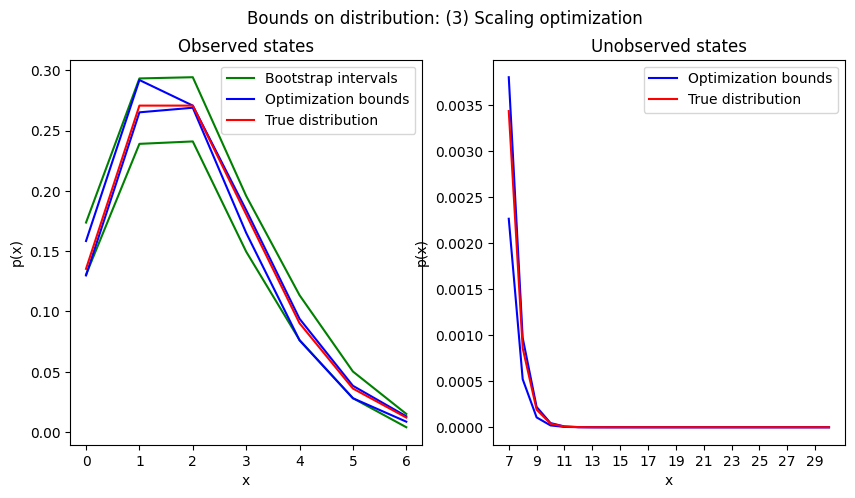

In [15]:
plot_distribution_results(prob_intervals, solution_3, beta, "(3) Scaling optimization")

# Capture efficiency

Investigate the performance of downsampled optimization across a range of capture efficiencies, comparing standard and scaling methods and the best settings to use

___

Use capture efficiency per cell distributed as:

$$ \beta \sim \text{Beta}(1, b) $$

Set values for mean capture and compute corresponding $b$ via $\text{mean} = \frac{1}{1 + b}$

## Standard Optimization (Downsampled)

### Effect of capture

Plot downsampled standard optimization bounds across a range of mean capture efficiencies.

In [8]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
M = 30

# simulate
sample = rng.poisson(k, size=n)

# mean capture range
mean_capture_range = [i / 10 for i in range(1, 11)]

# b range
b_range = [(1 / mean) - 1 for mean in mean_capture_range]

# store bounds
standard_bounds = np.empty((2, len(b_range)))

for i, b in enumerate(b_range):

    # sample capture
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=n)
    
    # downsample
    sample_downsampled = rng.binomial(sample, beta)

    # bootstrap
    tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

    # Downsampled standard optimization
    solution_standard = optimize_downsampled_standard(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, printing=False)

    # store
    standard_bounds[0, i] = solution_standard['min']
    standard_bounds[1, i] = solution_standard['max']

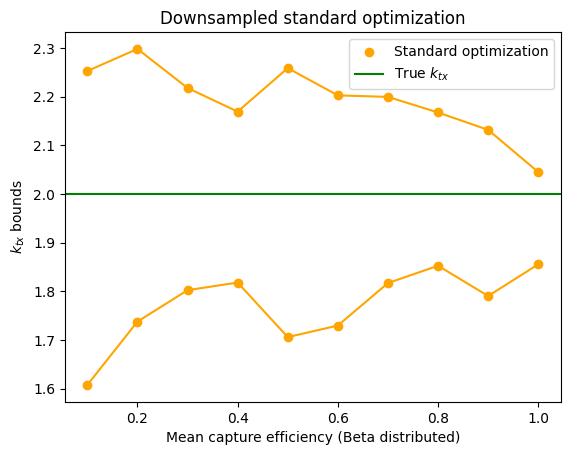

In [9]:
plt.scatter(mean_capture_range, standard_bounds[0, :], color="orange", label="Standard optimization")
plt.scatter(mean_capture_range, standard_bounds[1, :], color="orange")
plt.plot(mean_capture_range, standard_bounds[0, :], color="orange")
plt.plot(mean_capture_range, standard_bounds[1, :], color="orange")
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Mean capture efficiency (Beta distributed)")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Downsampled standard optimization")
plt.legend()

See that bounds generally widen as the capture efficiency decreases (as expected), but remain tight even for very low mean capture e.g. $10\%$ (Although note this is a very simple model)

### Effect of M

Assuming counts $x \in \{0, \ldots, m\}$ are observed (above a threshold # times) we then choose a value $M >> m$ as the maximum (unobserved) count $x$ considered i.e. largest probability variable used in distribution and CME constraints.

Does this choice have any effect on the results, and how much greater than $m$ does $M$ need to be?

In [12]:
# settings
k = 2
tau = 5
N = 1000
n = 1000

# simulate
sample = rng.poisson(k, size=n)

# mean capture range
mean_capture_range = [i / 10 for i in range(1, 11)]

# b range
b_range = [(1 / mean) - 1 for mean in mean_capture_range]

# M range
M_range = [6, 8, 10, 20, 30, 100]

# store bounds
standard_bounds_M = np.empty((2, len(b_range), len(M_range)))

for i, b in enumerate(b_range):

    # sample capture
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=n)
    
    # downsample
    sample_downsampled = rng.binomial(sample, beta)

    # bootstrap
    tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

    for j, M in enumerate(M_range):

        # Downsampled standard optimization
        solution_standard = optimize_downsampled_standard(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, printing=False)

        # store
        standard_bounds_M[0, i, j] = solution_standard['min']
        standard_bounds_M[1, i, j] = solution_standard['max']

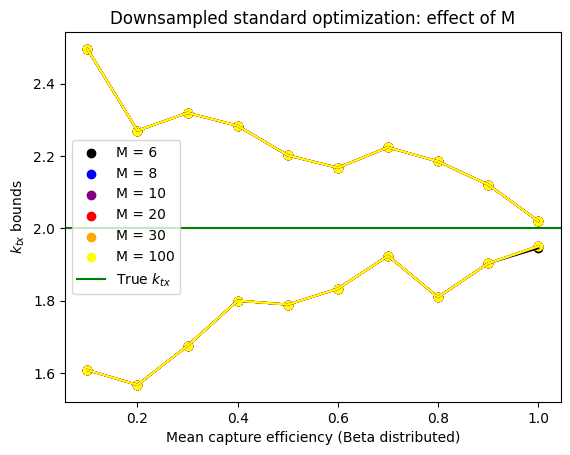

In [13]:
colours = ["black", "blue", "purple", "red", "orange", "yellow"]
for j, M in enumerate(M_range):
    plt.scatter(mean_capture_range, standard_bounds_M[0, :, j], color=colours[j], label=f"M = {M}")
    plt.scatter(mean_capture_range, standard_bounds_M[1, :, j], color=colours[j])
    plt.plot(mean_capture_range, standard_bounds_M[0, :, j], color=colours[j])
    plt.plot(mean_capture_range, standard_bounds_M[1, :, j], color=colours[j])
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Mean capture efficiency (Beta distributed)")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Downsampled standard optimization: effect of M")
plt.legend()

In [89]:
print(f"Maximum observed state m = {tmax}")

Maximum observed state m = 6


See that the choice of M does not affect results, even when setting equal to the largest state observed, although with a longer tail this is inadvisable and can cause infeasibility.

Setting $M < m$ is not possible given the current code setup (error below), but would mean throwing away information and assuming a smaller support, causing infeasibility even more often than for small $M$.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (8,).

## Scaling Optimization (Downsampled)

### Effect of UB and M

For a grid of $UB$ and $M$ values display the upper and lower bounds produced by downsampled scaling optimization to investigate their effects.

___

$UB$: unobserved mass p(unobs) upper bound \
$M$: largest (unobserved) state considered in constraints

In [18]:
from matplotlib.colors import LinearSegmentedColormap

In [75]:
# settings
k = 2
tau = 5
N = 1000
n = 1000

# capture
mean = 0.5
b = (1 / mean) - 1

# simulate
sample = rng.poisson(k, size=n)

# sample capture
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# downsample
sample_downsampled = rng.binomial(sample, beta)

# bootstrap
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)
print(f"tmax = {tmax}")

# compute true unobserved mass
p_obs = np.zeros(tmax + 1)
for b in beta:
    p_obs += scipy.stats.poisson.pmf([m for m in range(tmax + 1)], b * k) / len(beta)
m_obs = sum(p_obs)
m_unobs = 1 - sum(p_obs)
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

tmax = 5
p(obs) = 0.9968352834699017
p(unobs) = 0.0031647165300983104


In [ ]:
# un-observed mass range
UB_range = [m_unobs, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0] #np.linspace(m_unobs, 1.0, 8)

# M range
M_range = [5, 8, 10, 15, 20, 30, 50, 100]

# store bounds
scaling_bounds_grid = np.empty((2, len(UB_range), len(M_range)))

for i, UB in enumerate(UB_range):

    for j, M in enumerate(M_range):

        # Downsampled scaling optimization
        solution_scaling = optimize_downsampled_scaling(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=UB, printing=False)

        # store
        scaling_bounds_grid[0, i, j] = solution_scaling['min']
        scaling_bounds_grid[1, i, j] = solution_scaling['max']

In [83]:
def labels(names, labels=7, rnd=False):
    if rnd:
        names = [str(round(x, 3)) for x in names]
    nx = len(names)
    no_labels = 7
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = names[::step_x]
    return (x_positions, x_labels)

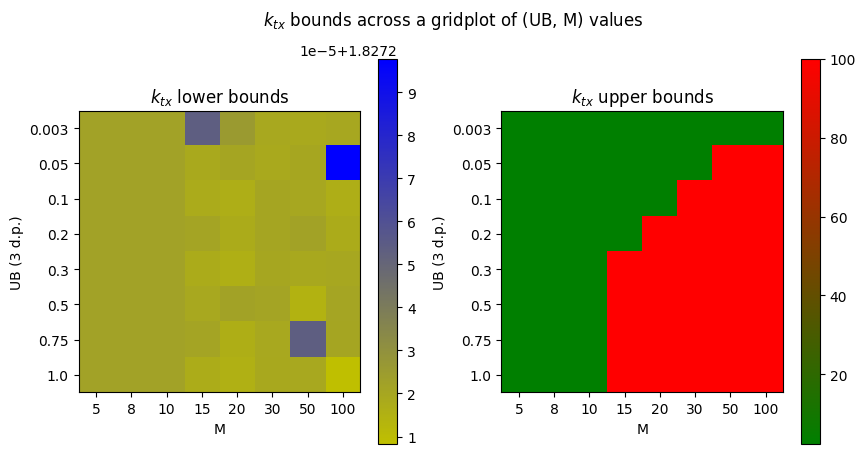

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# separate results
lower_bound_grid = scaling_bounds_grid[0, :, :]
upper_bound_grid = scaling_bounds_grid[1, :, :]

# lower bounds
cmap = LinearSegmentedColormap.from_list('yb', [(0, "y"), (1, "b")], N=256)
img_lb = axs[0].imshow(lower_bound_grid, cmap=cmap)#, vmin=vmin, vmax=vmax)
axs[0].set_title(r"$k_{tx}$ lower bounds")
cbar = plt.colorbar(img_lb, ax=axs[0])
#cbar.set_label("Lower bound")
axs[0].set_xticks(*labels(M_range))
axs[0].set_xlabel("M")
axs[0].set_yticks(*labels(UB_range, rnd=True))
axs[0].set_ylabel("UB (3 d.p.)")

# upper bounds
#vmin = 2
#vmax = 100
cmap = LinearSegmentedColormap.from_list('gr', [(0, "g"), (1, "r")], N=256)
img_ub = axs[1].imshow(upper_bound_grid, cmap=cmap)#, vmin=vmin, vmax=vmax)
axs[1].set_title(r"$k_{tx}$ upper bounds")
cbar = plt.colorbar(img_ub, ax=axs[1])
#cbar.set_label("Upper bound")
axs[1].set_xticks(*labels(M_range))
axs[1].set_xlabel("M")
axs[1].set_yticks(*labels(UB_range, rnd=True))
axs[1].set_ylabel("UB (3 d.p.)")

plt.suptitle(r"$k_{tx}$ bounds across a gridplot of (UB, M) values ")
plt.show()

In [79]:
print(f"True unobserved mass: p(unobs) = {m_unobs}")
print(f"Maximum observed state: m = {tmax}")

True unobserved mass: p(unobs) = 0.0031647165300983104
Maximum observed state: m = 5


Lower bounds are not affected by $UB$ or $M$, remaining constant at ~$1.8$ for a true value of $2$.

For large $UB$, upper bounds are mostly dependent on $M$: $M < 10$ gives good bounds of ~$2.3$, but $M > 10$ poor bounds of ~$100$. Interestingly, this switch happens very rapidly, and there are no cases of upper bounds with values inbetween.

However, when $UB$ becomes small this $M$ 'threshold' increases, until the top row, where $UB = p(unobs)$ true value, and the bounds no longer depend on $M$, with good results for all values.
___

Overall, the strong effect of $M$ suggests that the unbounded $f_{x}$ in the tail significantly weaken constraints, **unless** given a tight unobserved mass bound

In [85]:
# upper bound values for reference
upper_bound_grid

array([[  2.266651  ,   2.26665101,   2.26665101,   2.26655819,
          2.26665119,   2.26665469,   2.26665326,   2.2666521 ],
       [  2.266651  ,   2.266651  ,   2.266651  ,   2.26665129,
          2.26665214,   2.26660316,  99.9999857 ,  99.9999857 ],
       [  2.266651  ,   2.266651  ,   2.266651  ,   2.26665111,
          2.26665296,  99.99965346,  99.9999857 ,  99.9999857 ],
       [  2.266651  ,   2.266651  ,   2.26665101,   2.26665186,
        100.        , 100.        ,  99.9999857 ,  99.9999857 ],
       [  2.266651  ,   2.266651  ,   2.26665101,  99.9999857 ,
        100.        , 100.        ,  99.9999857 ,  99.9999857 ],
       [  2.266651  ,   2.266651  ,   2.26665332, 100.        ,
         99.9999857 , 100.        , 100.        ,  99.9999857 ],
       [  2.266651  ,   2.266651  ,   2.26665358,  99.99661355,
         99.99999944, 100.        ,  99.9999857 ,  99.9999857 ],
       [  2.266651  ,   2.26665101,   2.26665491, 100.        ,
         99.99965357, 100.       

### Effect of capture

Plot downsampled scaling bounds across a range of mean capture efficiencies, and repeat for different $UB$ and $M$ choices

In [117]:
# settings
k = 2
tau = 5
N = 1000
n = 1000

# simulate
sample = rng.poisson(k, size=n)

# mean capture range
mean_capture_range = [i / 10 for i in range(1, 11)]

# b range
b_range = [(1 / mean) - 1 for mean in mean_capture_range]

# UB range
UB_range = [0.05, 0.1, 0.2]

# M range
M_range = [10, 15, 30]

# store bounds
scaling_bounds_capture_grid = np.empty((2, len(UB_range), len(M_range), len(b_range)))

for o, b in enumerate(b_range):

    # sample capture
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=n)
    
    # downsample
    sample_downsampled = rng.binomial(sample, beta)

    # bootstrap
    tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)
            
    for i, UB in enumerate(UB_range):

        for j, M in enumerate(M_range):

            # Downsampled scaling optimization
            solution_scaling = optimize_downsampled_scaling(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=UB, printing=False)

            # store
            scaling_bounds_capture_grid[0, i, j, o] = solution_scaling['min']
            scaling_bounds_capture_grid[1, i, j, o] = solution_scaling['max']

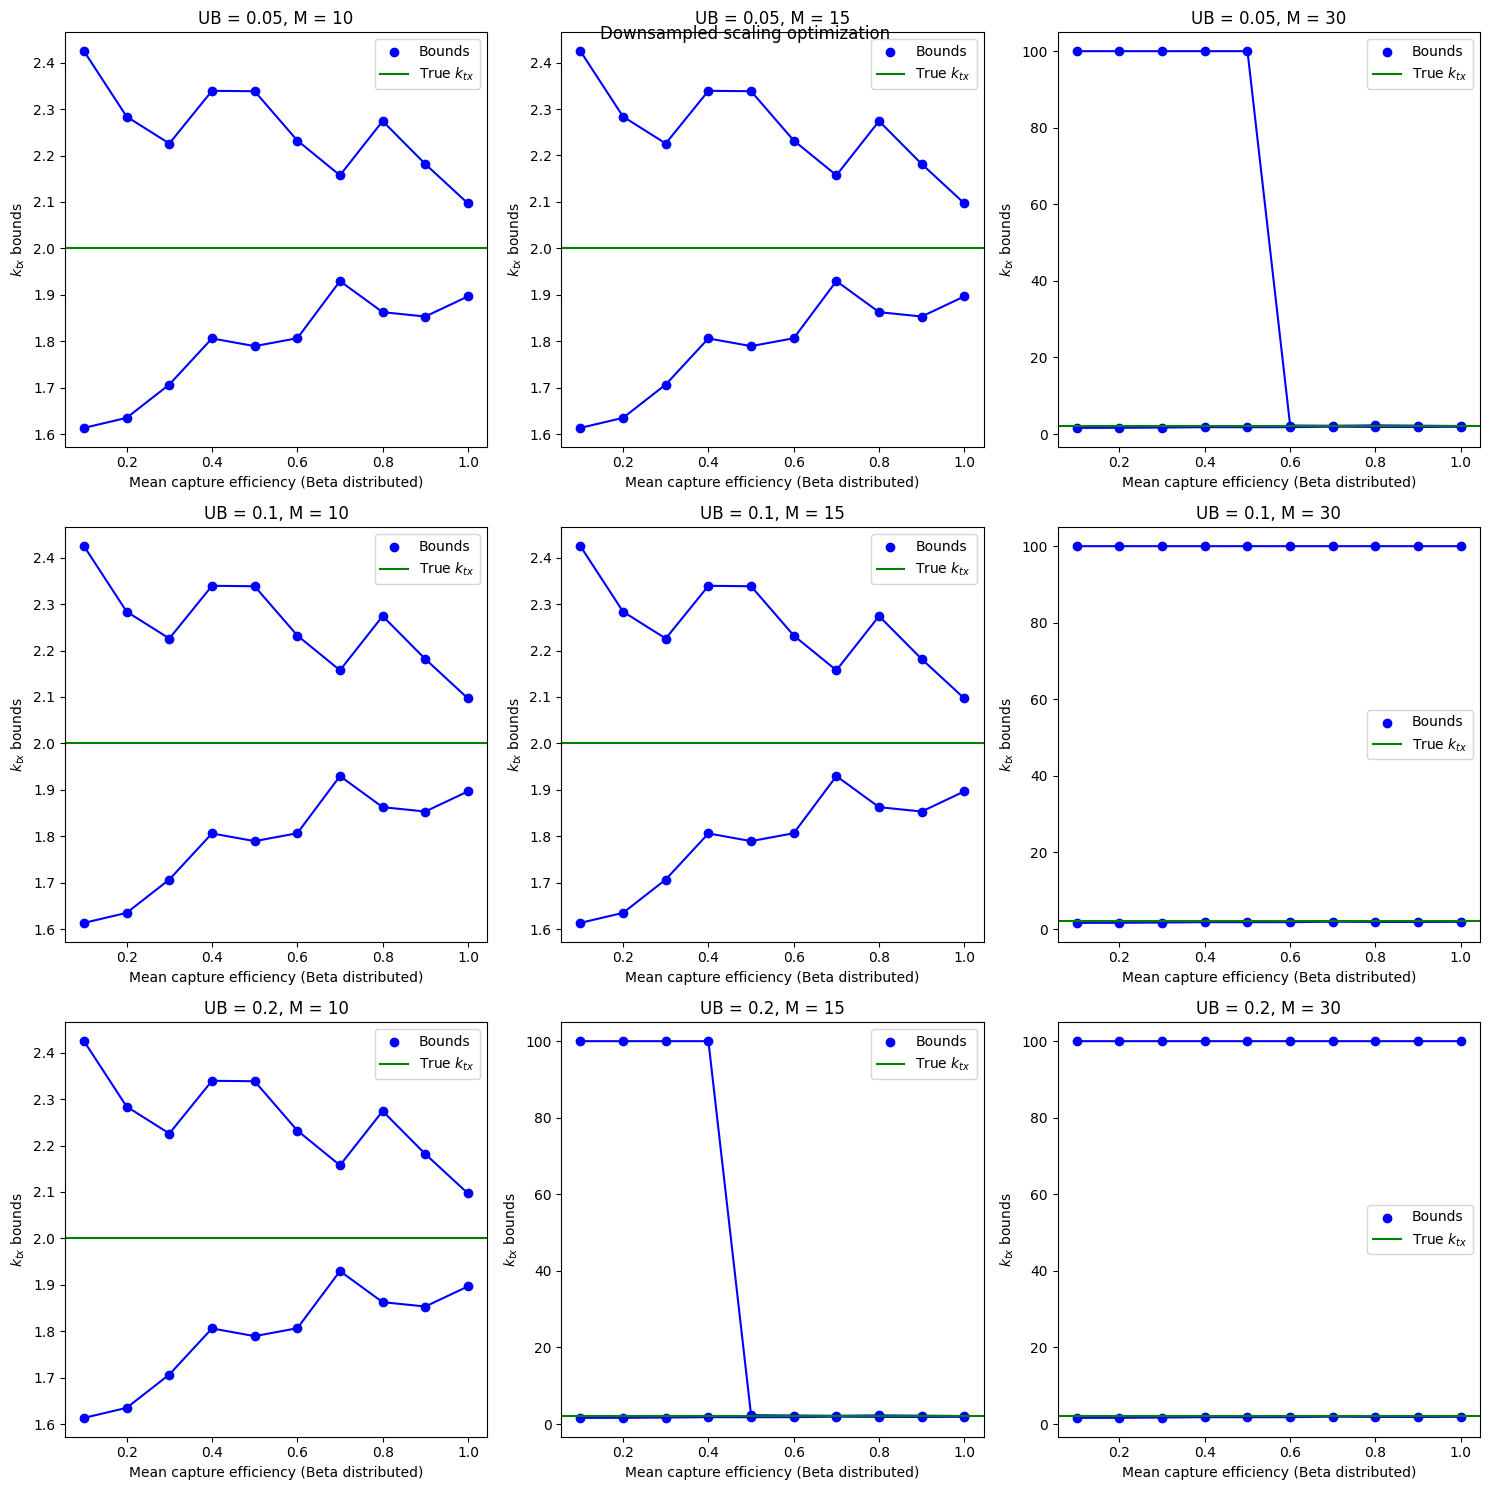

In [118]:
fig, axs = plt.subplots(len(UB_range), len(M_range), figsize=(15, 15))

for i, UB in enumerate(UB_range):
    for j, M in enumerate(M_range):
        axs[i, j].scatter(mean_capture_range, scaling_bounds_capture_grid[0, i, j, :], color="blue", label="Bounds")
        axs[i, j].scatter(mean_capture_range, scaling_bounds_capture_grid[1, i, j, :], color="blue")
        axs[i, j].plot(mean_capture_range, scaling_bounds_capture_grid[0, i, j, :], color="blue")
        axs[i, j].plot(mean_capture_range, scaling_bounds_capture_grid[1, i, j, :], color="blue")
        axs[i, j].set_title(f"UB = {UB}, M = {M}")
        axs[i, j].axhline(k, color="green", label=r"True $k_{tx}$")
        axs[i, j].set_xlabel("Mean capture efficiency (Beta distributed)")
        axs[i, j].set_ylabel(r"$k_{tx}$ bounds")
        axs[i, j].legend()

plt.tight_layout()
plt.suptitle("Downsampled scaling optimization")
plt.show()

Similar pattern to the gridtest above with a fixed capture: small $UB$ and/or $M$ are needed to produce good bounds.

Across the variety of $UB$, $M$ choices there are 3 types of results:

- (1) good bounds that widen slowly with decreasing capture
- (2) poor upper bounds of $K = 100$
- (3) bounds that change from (1) to (2) with decreasing capture

Type (3) is an intermediate kind of result not seen without capture variation, but there is still an instant increase in upper bound from ~$2$ to ~$100$ below a certain capture, rather than any gradual widening.

Note that, as shown below, the lower bounds for all $UB$ and $M$ settings remain the same:

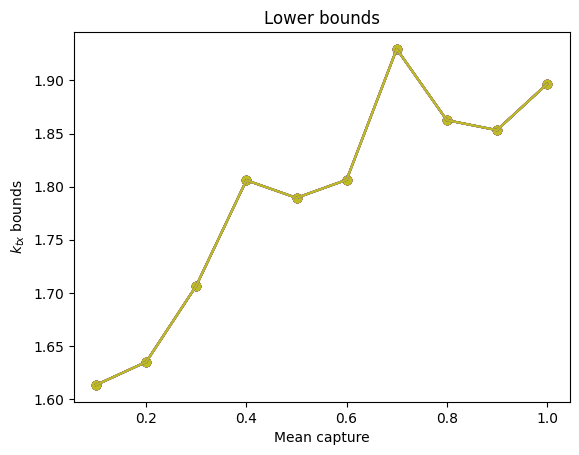

In [127]:
for i, _ in enumerate(UB_range):
    for j, _ in enumerate(M_range):
        plt.plot(mean_capture_range, scaling_bounds_capture_grid[0, i, j])
        plt.scatter(mean_capture_range, scaling_bounds_capture_grid[0, i, j])
plt.title("Lower bounds")
plt.xlabel("Mean capture")
plt.ylabel(r"$k_{tx}$ bounds")
plt.show()

#### Comparison to standard optimization

In [128]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
M = 15
UB = 0.1

# simulate
sample = rng.poisson(k, size=n)

# mean capture range
mean_capture_range = [i / 10 for i in range(1, 11)]

# b range
b_range = [(1 / mean) - 1 for mean in mean_capture_range]

# store bounds
standard_bounds = np.empty((2, len(b_range)))
scaling_bounds = np.empty((2, len(b_range)))

for i, b in enumerate(b_range):

    # sample capture
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=n)
    
    # downsample
    sample_downsampled = rng.binomial(sample, beta)

    # bootstrap
    tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

    # Downsampled standard optimization
    solution_standard = optimize_downsampled_standard(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, printing=False)

    # Downsampled scaling optimization
    solution_scaling = optimize_downsampled_scaling(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=UB, printing=False)

    # store
    standard_bounds[0, i] = solution_standard['min']
    standard_bounds[1, i] = solution_standard['max']

    scaling_bounds[0, i] = solution_scaling['min']
    scaling_bounds[1, i] = solution_scaling['max']

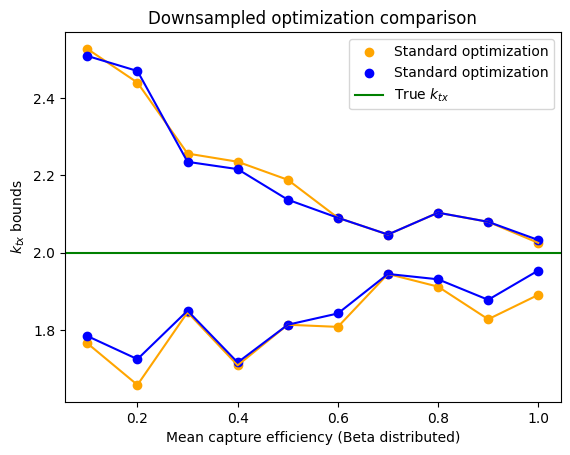

In [129]:
plt.scatter(mean_capture_range, standard_bounds[0, :], color="orange", label="Standard optimization")
plt.scatter(mean_capture_range, standard_bounds[1, :], color="orange")
plt.plot(mean_capture_range, standard_bounds[0, :], color="orange")
plt.plot(mean_capture_range, standard_bounds[1, :], color="orange")
plt.scatter(mean_capture_range, scaling_bounds[0, :], color="blue", label="Standard optimization")
plt.scatter(mean_capture_range, scaling_bounds[1, :], color="blue")
plt.plot(mean_capture_range, scaling_bounds[0, :], color="blue")
plt.plot(mean_capture_range, scaling_bounds[1, :], color="blue")
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Mean capture efficiency (Beta distributed)")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Downsampled optimization comparison")
plt.legend()

For a 'good bound' setting for scaling optimization we see the results produced are almost identical to standard optimization

## Alternate parameters

Change poisson parameter to give a more spread out stationary distribution and check if the same results occur

### Standard optimization

In [ ]:
# settings
k = 10
tau = 5
N = 1000
n = 1000

# simulate
sample = rng.poisson(k, size=n)

# mean capture range
mean_capture_range = [i / 10 for i in range(1, 11)]

# b range
b_range = [(1 / mean) - 1 for mean in mean_capture_range]

# M range
M_range = [6, 8, 10, 20, 30, 100]

# store bounds
standard_bounds_M = np.empty((2, len(b_range), len(M_range)))

for i, b in enumerate(b_range):

    # sample capture
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=n)
    
    # downsample
    sample_downsampled = rng.binomial(sample, beta)

    # bootstrap
    tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

    for j, M in enumerate(M_range):

        # Downsampled standard optimization
        try:
            solution_standard = optimize_downsampled_standard(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, printing=False)

            # store
            standard_bounds_M[0, i, j] = solution_standard['min']
            standard_bounds_M[1, i, j] = solution_standard['max']
        
        except:
            
            standard_bounds_M[0, i, j] = None
            standard_bounds_M[1, i, j] = None

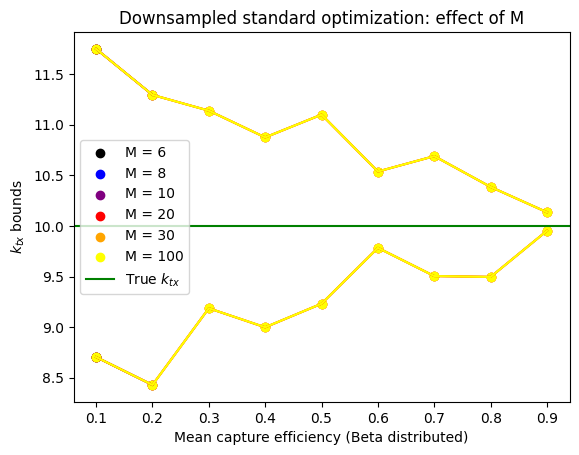

In [145]:
colours = ["black", "blue", "purple", "red", "orange", "yellow"]
for j, M in enumerate(M_range):
    plt.scatter(mean_capture_range, standard_bounds_M[0, :, j], color=colours[j], label=f"M = {M}")
    plt.scatter(mean_capture_range, standard_bounds_M[1, :, j], color=colours[j])
    plt.plot(mean_capture_range, standard_bounds_M[0, :, j], color=colours[j])
    plt.plot(mean_capture_range, standard_bounds_M[1, :, j], color=colours[j])
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Mean capture efficiency (Beta distributed)")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Downsampled standard optimization: effect of M")
plt.legend()

No change to result pattern: slow widening with decreasing capture and no effect of $M$.

### Scaling optimization

In [146]:
# settings
k = 10
tau = 5
N = 1000
n = 1000

# capture
mean = 0.5
b = (1 / mean) - 1

# simulate
sample = rng.poisson(k, size=n)

# sample capture
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# downsample
sample_downsampled = rng.binomial(sample, beta)

# bootstrap
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)
print(f"tmax = {tmax}")

# compute true unobserved mass
p_obs = np.zeros(tmax + 1)
for b in beta:
    p_obs += scipy.stats.poisson.pmf([m for m in range(tmax + 1)], b * k) / len(beta)
m_obs = sum(p_obs)
m_unobs = 1 - sum(p_obs)
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

tmax = 14
p(obs) = 0.9893659272051982
p(unobs) = 0.010634072794801774


In [147]:
# un-observed mass range
UB_range = [m_unobs, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0] #np.linspace(m_unobs, 1.0, 8)

# M range
M_range = [14, 16, 18, 20, 25, 30, 50, 100]

# store bounds
scaling_bounds_grid = np.empty((2, len(UB_range), len(M_range)))

for i, UB in enumerate(UB_range):

    for j, M in enumerate(M_range):

        # Downsampled scaling optimization
        solution_scaling = optimize_downsampled_scaling(M, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=UB, printing=False)

        # store
        scaling_bounds_grid[0, i, j] = solution_scaling['min']
        scaling_bounds_grid[1, i, j] = solution_scaling['max']

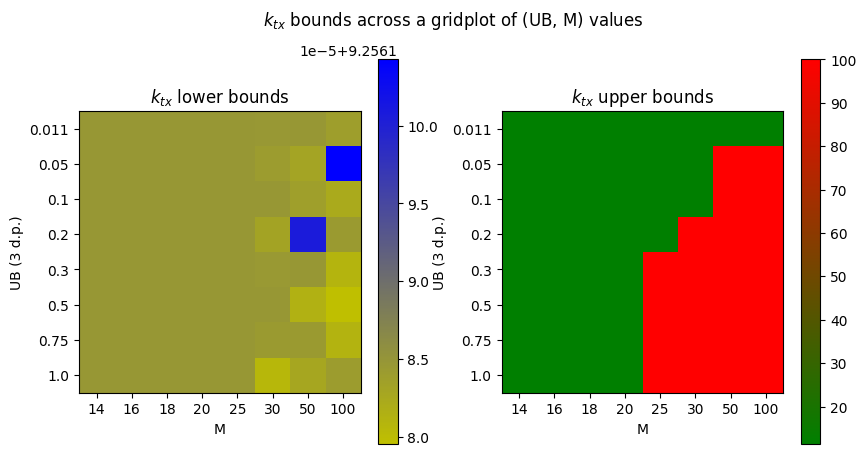

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# separate results
lower_bound_grid = scaling_bounds_grid[0, :, :]
upper_bound_grid = scaling_bounds_grid[1, :, :]

# lower bounds
cmap = LinearSegmentedColormap.from_list('yb', [(0, "y"), (1, "b")], N=256)
img_lb = axs[0].imshow(lower_bound_grid, cmap=cmap)#, vmin=vmin, vmax=vmax)
axs[0].set_title(r"$k_{tx}$ lower bounds")
cbar = plt.colorbar(img_lb, ax=axs[0])
#cbar.set_label("Lower bound")
axs[0].set_xticks(*labels(M_range))
axs[0].set_xlabel("M")
axs[0].set_yticks(*labels(UB_range, rnd=True))
axs[0].set_ylabel("UB (3 d.p.)")

# upper bounds
#vmin = 2
#vmax = 100
cmap = LinearSegmentedColormap.from_list('gr', [(0, "g"), (1, "r")], N=256)
img_ub = axs[1].imshow(upper_bound_grid, cmap=cmap)#, vmin=vmin, vmax=vmax)
axs[1].set_title(r"$k_{tx}$ upper bounds")
cbar = plt.colorbar(img_ub, ax=axs[1])
#cbar.set_label("Upper bound")
axs[1].set_xticks(*labels(M_range))
axs[1].set_xlabel("M")
axs[1].set_yticks(*labels(UB_range, rnd=True))
axs[1].set_ylabel("UB (3 d.p.)")

plt.suptitle(r"$k_{tx}$ bounds across a gridplot of (UB, M) values ")
plt.show()

Overall the pattern of results across $(UB, M)$ remains similar for a more spread out distribution. 

Perhaps a slightly larger range of $M$ values above the maximum observed produce good results: up to $20$ for max of $14$ vs up to $10$ for max of $6$, but few other changes.

## Notes

- too slow to optimize p for downsampled methods??